
# TCS Stock Data — Live & Latest (End‑to‑End ML Forecasting)

This notebook implements a robust, leakage‑safe pipeline for **TCS stock price forecasting** using:
- Clean EDA (plots, summary stats)
- Feature engineering (lags, rolling stats, RSI, MACD, volatility)
- Proper **time‑series splits** (no shuffling)
- Strong ML baselines (**Ridge**, **Random Forest**) and optional boosters (**XGBoost**, **CatBoost**) if available
- Optional lightweight **LSTM** (small footprint; trains on CPU/GPU if TensorFlow is present)
- Multiple metrics: **MAE, RMSE, MAPE, R², Directional Accuracy** (up/down correctness)
- Export of predictions & the trained best model

> **Data:** Download the CSV from the Drive link in your project PDF, then set `CSV_PATH` below.


In [1]:

# %% [code] Imports & Versions
import os, math, warnings, sys
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import RidgeCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

try:
    from xgboost import XGBRegressor
    HAS_XGB = True
except Exception:
    HAS_XGB = False

try:
    from catboost import CatBoostRegressor
    HAS_CAT = True
except Exception:
    HAS_CAT = False

try:
    import tensorflow as tf
    from tensorflow import keras
    HAS_TF = True
except Exception:
    HAS_TF = False

def rmse(y_true, y_pred):
    return np.sqrt(np.mean((y_true - y_pred)**2))

def mape(y_true, y_pred, eps=1e-9):
    denom = np.maximum(np.abs(y_true), eps)
    return np.mean(np.abs((y_true - y_pred)/denom)) * 100.0

def directional_accuracy(y_true, y_pred):
    # compares sign of daily change
    t = np.sign(np.diff(y_true))
    p = np.sign(np.diff(y_pred))
    n = min(len(t), len(p))
    if n == 0:
        return np.nan
    return (t[:n] == p[:n]).mean() * 100.0

print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("Scikit‑learn:", sys.modules.get('sklearn').__version__)
print("Has XGBoost:", HAS_XGB)
print("Has CatBoost:", HAS_CAT)
print("Has TensorFlow:", HAS_TF)


Python: 3.12.9
NumPy: 2.0.2
Pandas: 2.2.3
Scikit‑learn: 1.5.2
Has XGBoost: True
Has CatBoost: True
Has TensorFlow: True


In [2]:

# %% [code] Load CSV (set your path here)
# Example file names commonly seen for this dataset:
# 'TCS_stock_history.csv' OR 'TCS_stock_data.csv'.
CSV_PATH = r'C:\Users\Aksha\Downloads\TCS-Stock-data\TCS_stock_history.csv'  # <-- change if needed

assert os.path.exists(CSV_PATH), f"CSV not found at {CSV_PATH}. Please set correct path."

df = pd.read_csv(CSV_PATH)
print("Raw shape:", df.shape)
df.head()


Raw shape: (4463, 8)


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2002-08-12,28.794172,29.742206,28.794172,29.519140,212976,0.0,0.0
1,2002-08-13,29.556316,30.030333,28.905705,29.119476,153576,0.0,0.0
2,2002-08-14,29.184536,29.184536,26.563503,27.111877,822776,0.0,0.0
3,2002-08-15,27.111877,27.111877,27.111877,27.111877,0,0.0,0.0
4,2002-08-16,26.972458,28.255089,26.582090,27.046812,811856,0.0,0.0


In [3]:

# %% [code] Basic cleaning & typing
# Ensure canonical column names
df.columns = [c.strip().replace(' ', '_') for c in df.columns]

# Parse dates safely
date_col_guess = 'Date' if 'Date' in df.columns else [c for c in df.columns if 'date' in c.lower()][0]
df[date_col_guess] = pd.to_datetime(df[date_col_guess], errors='coerce')

# Sort by date ascending
df = df.sort_values(by=date_col_guess).reset_index(drop=True)

# Coerce numerics
num_cols = [c for c in df.columns if c != date_col_guess]
for c in num_cols:
    df[c] = pd.to_numeric(df[c], errors='coerce')

# Drop fully empty date rows, forward‑fill occasional numeric gaps
df = df.dropna(subset=[date_col_guess]).copy()
df[num_cols] = df[num_cols].ffill()

print(df.info())
df.tail(3)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4463 entries, 0 to 4462
Data columns (total 8 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          4463 non-null   datetime64[ns]
 1   Open          4463 non-null   float64       
 2   High          4463 non-null   float64       
 3   Low           4463 non-null   float64       
 4   Close         4463 non-null   float64       
 5   Volume        4463 non-null   int64         
 6   Dividends     4463 non-null   float64       
 7   Stock_Splits  4463 non-null   float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 279.1 KB
None


,Date,Open,High,Low,Close,Volume,Dividends,Stock_Splits
4460,2021-09-28,3850.000000,3850.0,3751.250000,3779.149902,2253075,0.0,0.0
4461,2021-09-29,3759.800049,3806.0,3722.149902,3791.899902,2489161,0.0,0.0
4462,2021-09-30,3805.000000,3805.0,3765.000000,3773.199951,640479,0.0,0.0


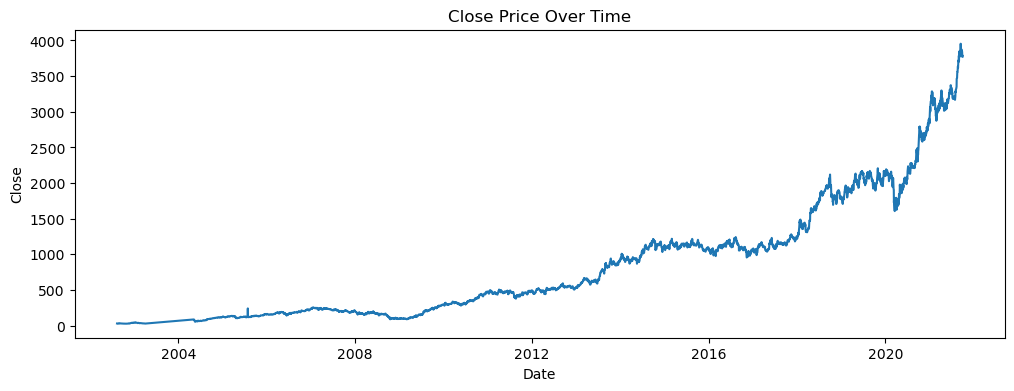

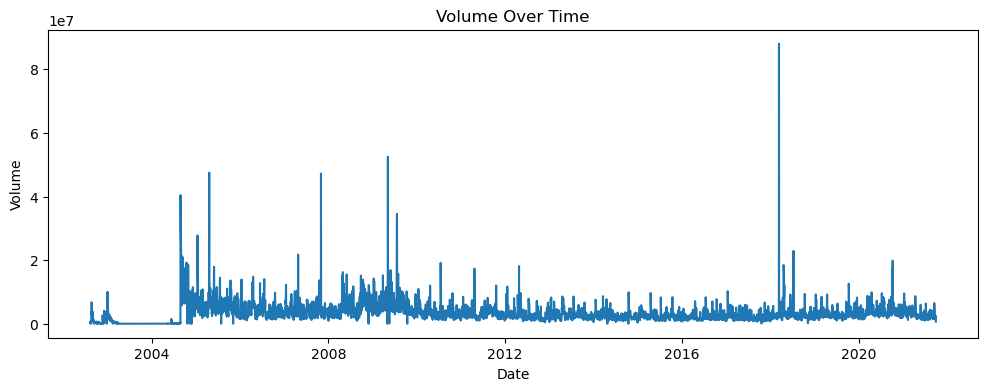

In [4]:

# %% [code] EDA — Close price & Volume over time
# Note: one chart per cell and no specific colors/styles by requirement.
close_col = 'Close' if 'Close' in df.columns else [c for c in df.columns if 'close' in c.lower()][0]
vol_col = 'Volume' if 'Volume' in df.columns else [c for c in df.columns if 'vol' in c.lower()][0]

plt.figure(figsize=(12,4))
plt.plot(df[date_col_guess], df[close_col])
plt.title('Close Price Over Time')
plt.xlabel('Date')
plt.ylabel('Close')
plt.show()

plt.figure(figsize=(12,4))
plt.plot(df[date_col_guess], df[vol_col])
plt.title('Volume Over Time')
plt.xlabel('Date')
plt.ylabel('Volume')
plt.show()


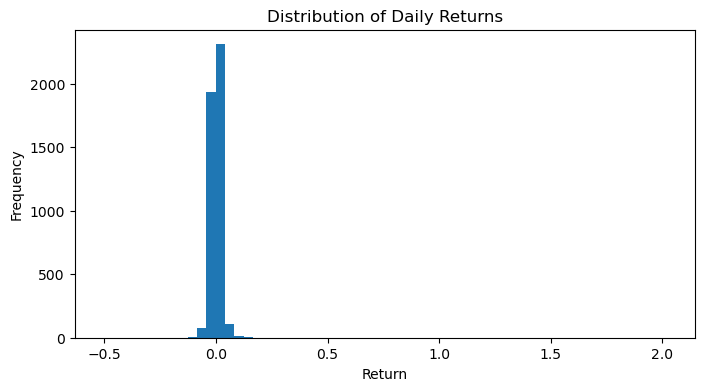

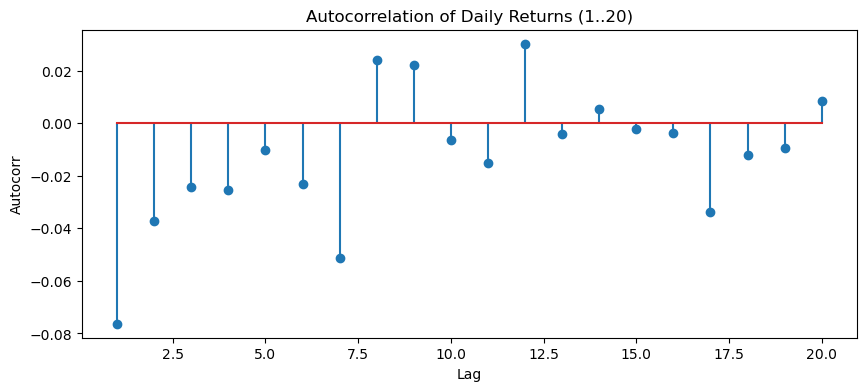

In [6]:

# %% [code] EDA — Returns distribution & simple autocorr
df['Return'] = df[close_col].pct_change()
plt.figure(figsize=(8,4))
plt.hist(df['Return'].dropna(), bins=60)
plt.title('Distribution of Daily Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.show()

# Simple autocorrelation of returns (few lags)
lags = 20
ac_vals = [df['Return'].autocorr(lag=i) for i in range(1, lags+1)]
plt.figure(figsize=(10,4))
plt.stem(range(1, lags+1), ac_vals)
plt.title('Autocorrelation of Daily Returns (1..20)')
plt.xlabel('Lag')
plt.ylabel('Autocorr')
plt.show()


In [7]:

# %% [code] Feature Engineering — Technical Indicators
high_col = 'High' if 'High' in df.columns else [c for c in df.columns if 'high' in c.lower()][0]
low_col  = 'Low'  if 'Low'  in df.columns else [c for c in df.columns if 'low'  in c.lower()][0]
open_col = 'Open' if 'Open' in df.columns else [c for c in df.columns if 'open' in c.lower()][0]

def SMA(s, window):
    return s.rolling(window).mean()

def EMA(s, span):
    return s.ewm(span=span, adjust=False).mean()

def RSI(series, period=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -1 * delta.clip(upper=0)
    ma_up = up.ewm(com=period-1, adjust=False).mean()
    ma_down = down.ewm(com=period-1, adjust=False).mean()
    rs = ma_up / (ma_down + 1e-9)
    return 100 - (100 / (1 + rs))

def MACD(series, fast=12, slow=26, signal=9):
    ema_fast = EMA(series, fast)
    ema_slow = EMA(series, slow)
    macd = ema_fast - ema_slow
    signal_line = EMA(macd, signal)
    hist = macd - signal_line
    return macd, signal_line, hist

def true_range(high, low, close):
    prev_close = close.shift(1)
    tr = pd.concat([high - low, (high - prev_close).abs(), (low - prev_close).abs()], axis=1).max(axis=1)
    return tr

def ATR(high, low, close, period=14):
    tr = true_range(high, low, close)
    return tr.rolling(period).mean()

# Lags & rolling stats
for lag in [1,2,3,5,10,20]:
    df[f'Close_lag_{lag}'] = df[close_col].shift(lag)
    df[f'Volume_lag_{lag}'] = df[vol_col].shift(lag)

for w in [5,10,20,50,100,200]:
    df[f'SMA_{w}'] = SMA(df[close_col], w)
    df[f'EMA_{w}'] = EMA(df[close_col], w)
    df[f'RollStd_{w}'] = df[close_col].rolling(w).std()
    df[f'RollMax_{w}'] = df[close_col].rolling(w).max()
    df[f'RollMin_{w}'] = df[close_col].rolling(w).min()

df['RSI_14'] = RSI(df[close_col], 14)
macd, macd_sig, macd_hist = MACD(df[close_col], 12, 26, 9)
df['MACD'] = macd
df['MACD_signal'] = macd_sig
df['MACD_hist'] = macd_hist
df['ATR_14'] = ATR(df[high_col], df[low_col], df[close_col], 14)

# Calendar features
df['Year'] = df[date_col_guess].dt.year
df['Month'] = df[date_col_guess].dt.month
df['Day'] = df[date_col_guess].dt.day
df['DayOfWeek'] = df[date_col_guess].dt.dayofweek

# Target: predict next‑day Close
df['Target_Close_next_1'] = df[close_col].shift(-1)

# Drop early NaN from indicators
df_ml = df.dropna().reset_index(drop=True)
print("ML frame shape:", df_ml.shape)
df_ml.head(3)


ML frame shape: (4263, 61)


,Date,Open,High,Low,Close,Volume,Dividends,Stock_Splits,Return,Close_lag_1,...,RSI_14,MACD,MACD_signal,MACD_hist,ATR_14,Year,Month,Day,DayOfWeek,Target_Close_next_1
0,2004-06-21,66.919920,68.407029,64.540547,65.451401,49328,0.0,0.0,-0.010678,66.157806,...,57.292482,2.579711,2.778401,-0.198691,3.886406,2004,6,21,0,63.927155
1,2004-06-22,65.432855,65.618744,63.573967,63.927155,20064,0.0,0.0,-0.023288,65.451401,...,54.565675,2.398212,2.702364,-0.304151,3.907651,2004,6,22,1,62.681683
2,2004-06-23,64.596334,65.061056,61.584935,62.681683,22912,0.0,0.0,-0.019483,63.927155,...,52.372257,2.129329,2.587757,-0.458428,3.887734,2004,6,23,2,63.722672


In [8]:

# %% [code] TimeSeries CV & Model training
target = 'Target_Close_next_1'
feature_cols = [c for c in df_ml.columns 
                if c not in [date_col_guess, target] and df_ml[c].dtype != 'datetime64[ns]']

X = df_ml[feature_cols].values
y = df_ml[target].values

tscv = TimeSeriesSplit(n_splits=5)
results = []

def fit_and_eval(name, model):
    fold = 0
    maes, rmses, mapes, r2s, dirs = [], [], [], [], []
    for train_idx, test_idx in tscv.split(X):
        fold += 1
        X_tr, X_te = X[train_idx], X[test_idx]
        y_tr, y_te = y[train_idx], y[test_idx]
        model.fit(X_tr, y_tr)
        pred = model.predict(X_te)
        maes.append(mean_absolute_error(y_te, pred))
        rmses.append(rmse(y_te, pred))
        mapes.append(mape(y_te, pred))
        r2s.append(r2_score(y_te, pred))
        dirs.append(directional_accuracy(y_te, pred))
    out = {
        "model": name,
        "MAE": np.mean(maes),
        "RMSE": np.mean(rmses),
        "MAPE%": np.mean(mapes),
        "R2": np.mean(r2s),
        "DirAcc%": np.mean(dirs)
    }
    return out

# 1) Ridge (scaled)
ridge = Pipeline([('scaler', StandardScaler(with_mean=False)), ('ridge', RidgeCV(alphas=np.logspace(-3,3,25)))])
results.append(fit_and_eval("RidgeCV", ridge))

# 2) RandomForest
rf = RandomForestRegressor(
    n_estimators=500,
    max_depth=None,
    min_samples_leaf=2,
    random_state=42,
    n_jobs=-1
)
results.append(fit_and_eval("RandomForest", rf))

# 3) XGBoost (optional)
if HAS_XGB:
    xgb = XGBRegressor(
        n_estimators=800,
        max_depth=8,
        subsample=0.8,
        colsample_bytree=0.8,
        learning_rate=0.03,
        objective='reg:squarederror',
        random_state=42,
        n_jobs=-1
    )
    results.append(fit_and_eval("XGBoost", xgb))

# 4) CatBoost (optional, quiet training)
if HAS_CAT:
    cat = CatBoostRegressor(
        iterations=1000,
        depth=8,
        learning_rate=0.03,
        loss_function='RMSE',
        random_seed=42,
        verbose=False
    )
    results.append(fit_and_eval("CatBoost", cat))

res_df = pd.DataFrame(results).sort_values(by="RMSE")
res_df


,model,MAE,RMSE,MAPE%,R2,DirAcc%
0,RidgeCV,13.702391,18.613758,2.071907,0.988743,51.255289
1,RandomForest,227.025930,316.981613,19.034118,-1.487784,50.832158
2,XGBoost,237.807513,327.762147,19.869575,-1.652750,50.126939
3,CatBoost,260.067357,341.802411,22.326412,-1.940238,51.368124


Best by CV: RidgeCV
Hold‑out MAE: 27.501991960587173
Hold‑out RMSE: 38.0458515670292
Hold‑out MAPE%: 1.2333263956427978
Hold‑out R²: 0.9956599249040291
Hold‑out DirAcc%: 51.173708920187785


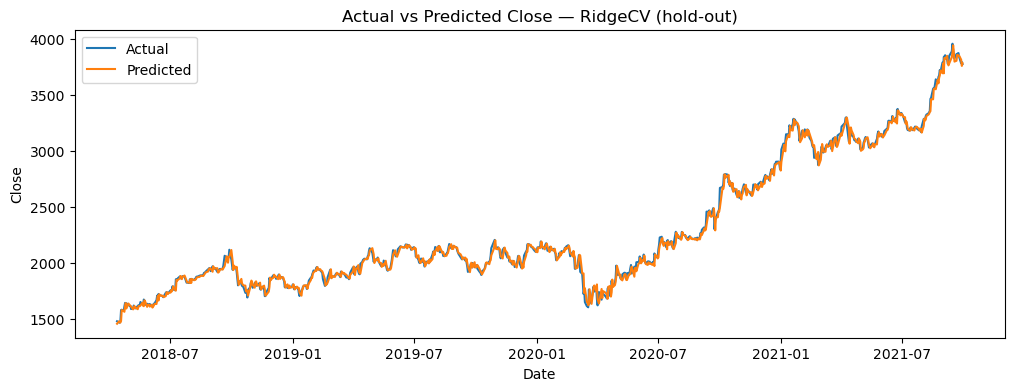

Saved predictions to: artifacts/tcs_predictions.csv
Saved model to: artifacts/best_model.joblib


In [9]:

# %% [code] Final Hold‑out Evaluation (last 20% of timeline)
best_name = res_df.iloc[0]['model']
print("Best by CV:", best_name)

def build_model(name):
    if name == "RidgeCV":
        return Pipeline([('scaler', StandardScaler(with_mean=False)), ('ridge', RidgeCV(alphas=np.logspace(-3,3,25)))])
    if name == "RandomForest":
        return RandomForestRegressor(n_estimators=500, max_depth=None, min_samples_leaf=2, random_state=42, n_jobs=-1)
    if name == "XGBoost" and HAS_XGB:
        return XGBRegressor(
            n_estimators=800, max_depth=8, subsample=0.8, colsample_bytree=0.8,
            learning_rate=0.03, objective='reg:squarederror', random_state=42, n_jobs=-1
        )
    if name == "CatBoost" and HAS_CAT:
        from catboost import CatBoostRegressor
        return CatBoostRegressor(iterations=1000, depth=8, learning_rate=0.03, loss_function='RMSE', random_seed=42, verbose=False)
    # Fallback
    return RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)

best_model = build_model(best_name)

N = len(df_ml)
split_idx = int(N * 0.8)
X_train, y_train = X[:split_idx], y[:split_idx]
X_test,  y_test  = X[split_idx:], y[split_idx:]

best_model.fit(X_train, y_train)
pred_test = best_model.predict(X_test)

print("Hold‑out MAE:", mean_absolute_error(y_test, pred_test))
print("Hold‑out RMSE:", rmse(y_test, pred_test))
print("Hold‑out MAPE%:", mape(y_test, pred_test))
print("Hold‑out R²:", r2_score(y_test, pred_test))
print("Hold‑out DirAcc%:", directional_accuracy(y_test, pred_test))

# Plot actual vs predicted (one chart in this cell)
dates_test = df_ml[date_col_guess].iloc[split_idx:]
plt.figure(figsize=(12,4))
plt.plot(dates_test, y_test, label='Actual')
plt.plot(dates_test, pred_test, label='Predicted')
plt.title(f'Actual vs Predicted Close — {best_name} (hold‑out)')
plt.xlabel('Date')
plt.ylabel('Close')
plt.legend()
plt.show()

# Save predictions & model
out_pred = pd.DataFrame({
    "Date": dates_test.values,
    "Actual_Close": y_test,
    "Predicted_Close": pred_test
})
os.makedirs("artifacts", exist_ok=True)
pred_path = "artifacts/tcs_predictions.csv"
out_pred.to_csv(pred_path, index=False)
print("Saved predictions to:", pred_path)

# Save model
try:
    import joblib
    model_path = "artifacts/best_model.joblib"
    joblib.dump(best_model, model_path)
    print("Saved model to:", model_path)
except Exception as e:
    print("Model save skipped:", e)


        feature  importance
0         Close    1.480435
1   Close_lag_1    0.218177
2         EMA_5    0.181581
3     RollMin_5    0.173876
4        EMA_20    0.137409
5     RollMax_5    0.113835
6        EMA_10    0.077781
7         SMA_5    0.060148
8        EMA_50    0.051676
9          High    0.037301
10  Close_lag_2    0.036702
11  Close_lag_3    0.029643
12       SMA_50    0.021235
13          Low    0.011370
14  Close_lag_5    0.010538
15   RollMin_10    0.008890
16   RollMax_10    0.007572
17       SMA_20    0.005963
18         Open    0.004225
19      EMA_200    0.004121


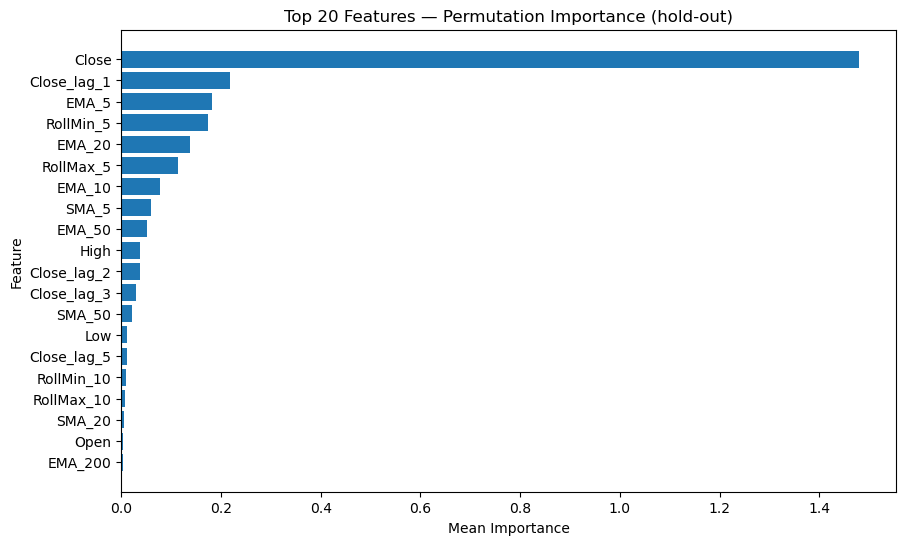

In [10]:

# %% [code] Permutation Importance (top 20)
from sklearn.inspection import permutation_importance

try:
    r = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    imp_df = pd.DataFrame({"feature": feature_cols, "importance": r.importances_mean}) \
                .sort_values("importance", ascending=False) \
                .head(20)
    imp_df.reset_index(drop=True, inplace=True)
    print(imp_df)

    plt.figure(figsize=(10,6))
    plt.barh(imp_df["feature"], imp_df["importance"])
    plt.gca().invert_yaxis()
    plt.title("Top 20 Features — Permutation Importance (hold‑out)")
    plt.xlabel("Mean Importance")
    plt.ylabel("Feature")
    plt.show()
except Exception as e:
    print("Permutation importance skipped:", e)


27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
LSTM MAE: 2283.371
LSTM RMSE: 2354.421
LSTM MAPE%: 99.214294


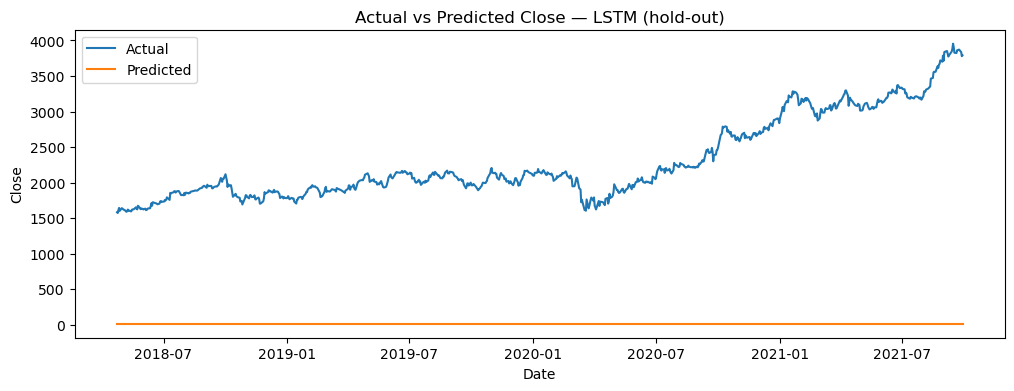

In [11]:

# %% [code] Optional: Lightweight LSTM (Close only), small lookback
if HAS_TF:
    series = df_ml[close_col].values.astype('float32')
    lookback = 30

    X_seq, y_seq = [], []
    for i in range(lookback, len(series)):
        X_seq.append(series[i-lookback:i])
        y_seq.append(series[i])
    X_seq, y_seq = np.array(X_seq), np.array(y_seq)
    X_seq = X_seq.reshape((X_seq.shape[0], X_seq.shape[1], 1))

    split_idx_seq = int(len(X_seq)*0.8)
    X_trs, X_tes = X_seq[:split_idx_seq], X_seq[split_idx_seq:]
    y_trs, y_tes = y_seq[:split_idx_seq], y_seq[split_idx_seq:]

    model = keras.Sequential([
        keras.layers.Input(shape=(lookback,1)),
        keras.layers.LSTM(32),
        keras.layers.Dense(1)
    ])
    model.compile(optimizer="adam", loss="mse")
    hist = model.fit(X_trs, y_trs, epochs=12, batch_size=64, verbose=0)

    y_hat = model.predict(X_tes).ravel()
    print("LSTM MAE:", mean_absolute_error(y_tes, y_hat))
    print("LSTM RMSE:", rmse(y_tes, y_hat))
    print("LSTM MAPE%:", mape(y_tes, y_hat))

    # Plot
    dates_seq_test = df_ml[date_col_guess].iloc[-len(y_tes):]
    plt.figure(figsize=(12,4))
    plt.plot(dates_seq_test, y_tes, label='Actual')
    plt.plot(dates_seq_test, y_hat, label='Predicted')
    plt.title('Actual vs Predicted Close — LSTM (hold‑out)')
    plt.xlabel('Date')
    plt.ylabel('Close')
    plt.legend()
    plt.show()
else:
    print("TensorFlow not found — skipping LSTM block.")



## Notes & Next Steps
- Results above are **leakage‑safe** (lags/rollings only use past data; time‑series splits).
- If available in your env, **XGBoost/CatBoost** often improve RMSE/MAE vs linear/forest baselines.
- For even richer signals, consider:
  - More engineered alpha factors (e.g., rolling skew/kurtosis, drawdowns, OBV).
  - Multivariate LSTM/Temporal Convolution over full feature set (ensure small sizes for 4GB GPU).
  - Regime detection (volatility states) and model ensembling per regime.
- Always validate with **walk‑forward** evaluation and track **directional accuracy** for trading relevance.
